<a href="https://colab.research.google.com/github/MucaCirone/Master_Thesis/blob/main/Fourier_Features_rSigKer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows some empirical convergence results concerning Randomized Signature Kernels as discussed in my master's thesis.

# Importing Libraries

In [1]:
!pip install git+https://github.com/patrick-kidger/torchcde.git
!pip install git+https://github.com/crispitagorico/sigkernel.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/patrick-kidger/torchcde.git to /tmp/pip-req-build-ia9emnu8
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-req-build-ia9emnu8
     |████████████████████████████████| 59 kB 4.0 MB/s 
     |████████████████████████████████| 193 kB 24.3 MB/s 
  Created wheel for torchcde: filename=torchcde-0.2.5-py3-none-any.whl size=28902 sha256=0dbf604188f8073c38c2247a921efdd76b21acf3e33e9dac81866cbaf55059b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0m7kk9v/wheels/57/9e/98/bdb1daad21c5227d3460cdc8cc0dd9e6cb6ef8aeafbcc8505d
Successfully built torchcde
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/crispitagorico/sigkernel.git to /tmp/pip-req-build-cl6lwy_3
  Running command git clone -q https://github.com/crispitagorico/sigkernel.git /tmp/pip-req-build

In [2]:
import torch
import torchcde
from tqdm import tqdm

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg
import random


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

import matplotlib.pyplot as plt

import seaborn as sns
import scipy
import sklearn.metrics as metrics

sns.set_context('notebook')

import sigkernel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# rSig - CDE code

In [3]:
def randomAbeta(n_vec: int, m: int, mean=0.0, sigma=0.03, distribution=torch.normal):
    # Creates n_vec random mxm matrix A and mx1 vector beta
    # Entries have distribution 'distribution'

    A = []
    beta = []
    Gamma = []

    for i in range(n_vec):
        # B = 0.0*nilpotent(m) + np.random.normal(mean, sigma, size=(m, m))
        B = distribution(mean, sigma, size=(m, m)).to(device)
        A = A + [B]
        b = distribution(mean, sigma, size=(1,m)).squeeze(0).to(device)
        beta = beta + [b]
        Gamma = Gamma + [torch.cat((B,b.unsqueeze(-1)),1)]


    return [torch.stack(A),torch.stack(beta),torch.stack(Gamma)]

In [4]:
class DrivingFields(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, sigma = 1.0, bias = True):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(DrivingFields, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        _,_,self.Gamma = randomAbeta(input_channels,hidden_channels, sigma= sigma)
        
        if not bias:
          self.Gamma[:,:,-1] = 0.

    def forward(self, t, z):
        # z : (batch, hidden_channels)
        batch = z.shape[0]
        z = torch.cat((z, torch.ones([batch,1]).to(device)),1) # z -> [z,1]
        z = z.unsqueeze(-2).unsqueeze(-1) # (batch,n+1) -> (batch,1,n+1,1)
        G = self.Gamma.expand(1,-1,-1,-1) # (d, n, n+1) -> (1, d, n, n+1)
        res = torch.matmul(G,z) # (batch, d, n, 1) 
        res = res.squeeze(-1) # (batch, d, n, 1) -> (batch, d, n)
        res = torch.swapaxes(res, -2, -1) # (batch, d, n) -> (batch, n, d)
        #res = res.tanh()
        return res

In [5]:
######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class rSig(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, bias = True):
        super(rSig, self).__init__()
        sigma = 1/np.sqrt(hidden_channels)

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.fields = DrivingFields(input_channels, hidden_channels, sigma, bias)
        self.z0 = sigma*torch.normal(0,1,size = [self.hidden_channels]).to(device)

        

    def forward(self, coeffs):
        batch = coeffs.shape[0]
        X = torchcde.interpolation_cubic.NaturalCubicSpline(coeffs)

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = (self.z0).expand(batch, -1)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.fields,
                              t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        return z_T

# Data

Cration of the datasets. Credit goes to Maud Lemercier (https://warwick.ac.uk/fac/sci/statistics/staff/research_students/mlemercier).

In [6]:
def exponentiated_quadratic(xa, xb, sigma):
    """
    Exponentiated quadratic  with σ = 1
    i.e. exp ( - 1/2\sigma * [squared euclidean distance matrix of elements in xa and xb])
    """
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm/sigma)

In [7]:
# Synthetic data
batch, len_x, len_y = 400, 10, 10

# Independent variable samples
U = np.expand_dims(np.linspace(-2, 2, len_x), 1)
Sigma = exponentiated_quadratic(U, U, sigma=.25)  # Kernel of data points 

# Draw samples 
y1 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
y2 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
y3 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
x1 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
x2 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)
x3 = np.random.multivariate_normal(mean=np.zeros(len_x), cov=Sigma, size=batch)

x = .15*np.stack([x1,x2,x3],axis=2)
y = .15*np.stack([y1,y2,y3],axis=2)

# x.shape  -- (400, 10, 3)

# Linear SigKer - computation


In [8]:
# Specify the static kernel (for linear kernel use sigkernel.LinearKernel())
static_kernel = sigkernel.LinearKernel()

# Specify dyadic order for PDE solver (int > 0, default 0, the higher the more accurate but slower)
dyadic_order = 4

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

# Compute signature kernel "batch-wise" (i.e. k(x_1,y_1),...,k(x_batch, y_batch))
sk = signature_kernel.compute_kernel(torch.tensor(x), torch.tensor(y))

# rSigKer - computation

With Bias

In [9]:
new_x = torch.tensor(x).to(device)
new_y = torch.tensor(y).to(device)

In [12]:
MC_iterations = 15
hidden_dim = 250

prods = torch.zeros([new_x.shape[0]]).to(device)

for m in tqdm(range(MC_iterations)):

  model = rSig(input_channels = 3, hidden_channels = hidden_dim)
  
  coeffs_x = torchcde.natural_cubic_coeffs(new_x).float()
  sigs_x = model.forward(coeffs_x)

  coeffs_y = torchcde.natural_cubic_coeffs(new_y).float()
  sigs_y = model.forward(coeffs_y)

  prods += torch.matmul(sigs_x.unsqueeze(-2),sigs_y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

prods = prods/MC_iterations
prods = prods.cpu().detach().numpy()

100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


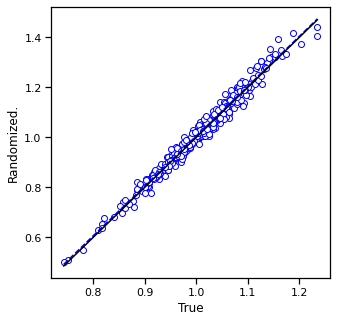

R2: 0.9764915762876626


In [13]:
new_sk = sk
new_prods = prods 

plt.figure(figsize=(5,5))
plt.scatter(new_sk, new_prods, edgecolors='blue', color='white')
plt.plot(np.unique(new_sk), np.poly1d(np.polyfit(new_sk, new_prods, 1))(np.unique(new_sk)), color='blue', ls='--')
plt.plot(np.unique(new_sk), 2*np.unique(new_sk) - 1,'k-')
plt.xlabel('True')
plt.ylabel('Randomized.')
plt.show()
print('R2:', metrics.r2_score(2*new_sk-1, new_prods))

Without Bias

In [12]:
MC_iterations = 15
hidden_dim = 250

prods_ = torch.zeros([new_x.shape[0]]).to(device)

for m in tqdm(range(MC_iterations)):

  model = rSig(input_channels = 3, hidden_channels = hidden_dim, bias = False)
  
  coeffs_x = torchcde.natural_cubic_coeffs(new_x).float()
  sigs_x = model.forward(coeffs_x)

  coeffs_y = torchcde.natural_cubic_coeffs(new_y).float()
  sigs_y = model.forward(coeffs_y)

  prods_ += torch.matmul(sigs_x.unsqueeze(-2),sigs_y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

prods_ = prods_/MC_iterations
prods_ = prods_.cpu().detach().numpy()

100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


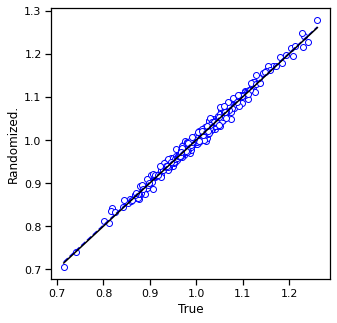

R2: 0.9879572489385599


In [13]:
new_sk = sk
new_prods = prods_

plt.figure(figsize=(5,5))
plt.scatter(new_sk, new_prods, edgecolors='blue', color='white')
plt.plot(np.unique(new_sk), np.poly1d(np.polyfit(new_sk, new_prods, 1))(np.unique(new_sk)), color='blue', ls='--')
plt.plot(np.unique(new_sk), np.unique(new_sk),'k-')
plt.xlabel('True')
plt.ylabel('Randomized.')
plt.show()
print('R2:', metrics.r2_score(new_sk, new_prods))

# RBF SigKer - Computation

In [52]:
# Specify the static kernel (for linear kernel use sigkernel.LinearKernel())
sigma = 2.
static_kernel = sigkernel.RBFKernel(sigma=sigma)

# Specify dyadic order for PDE solver (int > 0, default 0, the higher the more accurate but slower)
dyadic_order = 4

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

# Compute signature kernel "batch-wise" (i.e. k(x_1,y_1),...,k(x_batch, y_batch))
sk = signature_kernel.compute_kernel(torch.tensor(x), torch.tensor(y))

Text(0.5, 0, 'Bins')

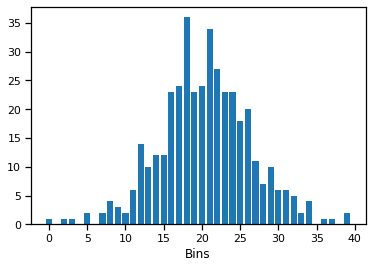

In [53]:
bins = 40
hist = torch.histc(sk, bins=bins, min = sk.min(), max = sk.max())

plt.bar(range(bins), hist, align='center')
plt.xlabel('Bins')

# rSigKer w/ Fourier Features - Computation

The Fourier Features Feature map is, given $\phi: \mathbb{R}^n \to \mathbb{R}^M$ given by
$$
  \phi(x) = \sqrt{\frac{2}{M}} \cos(Wx + b)
$$

where the entries of $W \in \mathbb{R}^{M \times n}$ are $\mathcal{N}(0,1)$, the entries of $b \in \mathbb{R}^M$ are uniformly sampled from $[0,2\pi]$ and $\cos$ is applied componentwise.

In [54]:
n = x.shape[-1]
M = 100

W = np.sqrt(2/sigma)*torch.normal(0.0, 1.0, size = (M, n)).to(device)
b = 2*torch.pi*torch.rand(M).to(device)

def phi(x): 
  return np.sqrt(2/M)*torch.cos(torch.matmul(W,x.unsqueeze(-1)).squeeze(-1) + b)

x_ = torch.tensor(x).float().to(device)
y_ = torch.tensor(y).float().to(device)

# x_ = phi(np.sqrt(2/sigma)*x_)
# y_ = phi(np.sqrt(2/sigma)*y_)
x_ = phi(x_)
y_ = phi(y_)

In [55]:
MC_iterations = 15
hidden_dim = 100

prods = torch.zeros([new_x.shape[0]]).to(device)

for m in tqdm(range(MC_iterations)):

  model = rSig(input_channels = M, hidden_channels = hidden_dim)
  
  coeffs_x = torchcde.natural_cubic_coeffs(x_).float()
  sigs_x = model.forward(coeffs_x)

  coeffs_y = torchcde.natural_cubic_coeffs(y_).float()
  sigs_y = model.forward(coeffs_y)

  prods += torch.matmul(sigs_x.unsqueeze(-2),sigs_y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

prods = prods/MC_iterations
prods = prods.cpu().detach().numpy()

100%|██████████| 15/15 [01:07<00:00,  4.52s/it]


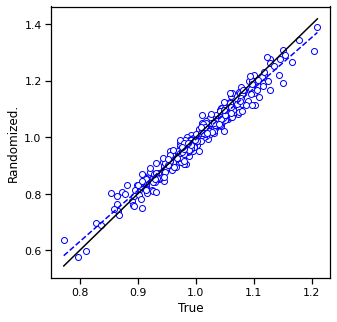

R2: 0.9532683878726524


In [56]:
new_sk = sk
new_prods = prods 

plt.figure(figsize=(5,5))
plt.scatter(new_sk, new_prods, edgecolors='blue', color='white')
plt.plot(np.unique(new_sk), np.poly1d(np.polyfit(new_sk, new_prods, 1))(np.unique(new_sk)), color='blue', ls='--')
plt.plot(np.unique(new_sk), 2*np.unique(new_sk) - 1,'k-')
plt.xlabel('True')
plt.ylabel('Randomized.')
plt.show()
print('R2:', metrics.r2_score(2*new_sk-1, new_prods))